# SNN_Conversion.ipynb

In [2]:
# %%
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchaudio
import torchaudio.transforms as T

import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

import snntorch as snn
from snntorch import surrogate

# For audio loading without torchcodec
import soundfile as sf


# -------------------------------
# FIXED: Project root = parent of this folder
# -------------------------------
CURRENT_DIR = Path.cwd()
PROJECT_ROOT = CURRENT_DIR.parent               # <---- FIXED
DATA_ROOT = PROJECT_ROOT / "sample_data" / "speech_commands_v0.02"
MODEL_DIR = PROJECT_ROOT / "saved_models"

print("Notebook directory:", CURRENT_DIR)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT exists:", DATA_ROOT.exists())
print("MODEL_DIR exists:", MODEL_DIR.exists())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Notebook directory: /Users/maddy/Desktop/PLEP/Project/CS-576-Final-Project/snn_conversion
PROJECT_ROOT: /Users/maddy/Desktop/PLEP/Project/CS-576-Final-Project
DATA_ROOT exists: True
MODEL_DIR exists: True
Using device: cpu


In [3]:
# %%
# Keywords (same as baseline CNN)
CLASSES = ["yes", "no", "go", "stop", "down", "up"]

SAMPLE_RATE = 16000
N_MFCC = 40

# MFCC transform (same configuration as training)
mfcc_transform = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=N_MFCC,
    melkwargs={
        "n_fft": 400,
        "hop_length": 160,
        "n_mels": 40,
        "center": False,
    },
)

def wav_to_mfcc(path: Path) -> torch.Tensor:
    """
    Load WAV file using soundfile + compute MFCCs.
    Returns tensor [40, T].
    """
    # soundfile returns (samples, sr)
    waveform, sr = sf.read(str(path))
    waveform = torch.tensor(waveform).float().unsqueeze(0)  # [1, N]

    if sr != SAMPLE_RATE:
        waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)

    mfcc = mfcc_transform(waveform).squeeze(0)  # [40, T]

    # per-sample normalization (same style as training)
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-6)
    mfcc = torch.clamp(mfcc, -2.0, 2.0)
    return mfcc

In [4]:
# %%
# Helpers to read the official val/test splits
val_list_path = DATA_ROOT / "validation_list.txt"
test_list_path = DATA_ROOT / "testing_list.txt"

def read_split_list(path: Path):
    with open(path, "r") as f:
        return [line.strip() for line in f.readlines()]

val_rel = set(read_split_list(val_list_path))
test_rel = set(read_split_list(test_list_path))

def make_file_lists(data_root: Path, classes):
    train_files, val_files, test_files = [], [], []

    for cls in classes:
        cls_dir = data_root / cls
        if not cls_dir.exists():
            continue
        for wav_path in cls_dir.glob("*.wav"):
            rel = f"{cls}/{wav_path.name}"
            if rel in val_rel:
                val_files.append(wav_path)
            elif rel in test_rel:
                test_files.append(wav_path)
            else:
                train_files.append(wav_path)

    return train_files, val_files, test_files

train_files, val_files, test_files = make_file_lists(DATA_ROOT, CLASSES)

print(f"Train files: {len(train_files)}")
print(f"Val files:   {len(val_files)}")
print(f"Test files:  {len(test_files)}")

Train files: 18657
Val files:   2252
Test files:  2468


In [5]:
# %%
class KWS_Dataset(Dataset):
    def __init__(self, file_list, classes):
        self.files = file_list
        self.classes = classes

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        mfcc = wav_to_mfcc(path)  # [40, T]
        label_name = path.parent.name
        y = self.classes.index(label_name)
        return mfcc, y

def pad_collate(batch):
    xs, ys = zip(*batch)
    max_t = max(x.shape[1] for x in xs)
    xs = [F.pad(x, (0, max_t - x.shape[1])) for x in xs]
    xs = torch.stack(xs)  # [B,40,T]
    ys = torch.tensor(ys)
    return xs, ys

BATCH_SIZE = 128

train_dataset = KWS_Dataset(train_files, CLASSES)
val_dataset   = KWS_Dataset(val_files, CLASSES)
test_dataset  = KWS_Dataset(test_files, CLASSES)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=pad_collate, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=pad_collate, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=pad_collate, num_workers=0)

print("Train:", len(train_dataset), "| Val:", len(val_dataset), "| Test:", len(test_dataset))

Train: 18657 | Val: 2252 | Test: 2468


In [11]:
class CNN_KWS(nn.Module):
    def __init__(self, num_classes=6, flatten_dim=3840):
        super().__init__()

        self.flatten_dim = flatten_dim

        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = x.unsqueeze(1)           # [B,1,40,T]
        x = self.features(x)
        x = torch.flatten(x, 1)      # [B, F]

        F = x.shape[1]

        # 👇 CRITICAL: match checkpoint’s expected flatten_dim (3840)
        if F > self.flatten_dim:
            x = x[:, :self.flatten_dim]
        elif F < self.flatten_dim:
            pad = self.flatten_dim - F
            x = F.pad(x, (0, pad))  # pad at end

        return self.classifier(x)

In [13]:
cnn_ckpt_path = MODEL_DIR / "baseline_cnn_kws_vfinal.pt"

print("CNN checkpoint exists:", cnn_ckpt_path.exists())

# Load checkpoint just to get flatten_dim
state_dict = torch.load(cnn_ckpt_path, map_location=device)
flatten_dim_ckpt = state_dict["classifier.0.weight"].shape[1]
print("Flatten dim in checkpoint =", flatten_dim_ckpt)

# Build CNN using correct flatten_dim
cnn_model = CNN_KWS(num_classes=6, flatten_dim=flatten_dim_ckpt).to(device)

# Load weights
cnn_model.load_state_dict(state_dict)
cnn_model.eval()

print("CNN loaded successfully.")

CNN checkpoint exists: True
Flatten dim in checkpoint = 3840
CNN loaded successfully.


In [14]:
# %%
@torch.no_grad()
def eval_cnn(loader, model, device=device):
    model.eval()
    correct = 0
    total = 0
    for mfcc, y in tqdm(loader, desc="Eval CNN"):
        mfcc, y = mfcc.to(device), y.to(device)
        logits = model(mfcc)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.numel()
    return correct / total

val_acc_cnn = eval_cnn(val_loader, cnn_model, device)
test_acc_cnn = eval_cnn(test_loader, cnn_model, device)

print(f"CNN VAL  Accuracy: {val_acc_cnn*100:.2f}%")
print(f"CNN TEST Accuracy: {test_acc_cnn*100:.2f}%")

Eval CNN: 100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.90it/s]

CNN VAL  Accuracy: 81.79%
CNN TEST Accuracy: 80.43%


In [15]:
# %%
spike_grad = surrogate.fast_sigmoid()

class SNN_KWS(nn.Module):
    def __init__(self, base_cnn: CNN_KWS, num_steps: int = 50, beta: float = 0.95):
        super().__init__()
        self.num_steps = num_steps
        self.features = base_cnn.features
        self.fc1 = base_cnn.classifier[0]  # LazyLinear/Linear -> 64
        self.fc2 = base_cnn.classifier[2]  # Linear 64 -> num_classes

        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        """
        x: [B,40,T]
        Returns: [T,B,num_classes] spike tensor.
        """
        spk2_rec = []
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # encode static MFCC as constant input across time
        x = x.unsqueeze(1)  # [B,1,40,T]

        for _ in range(self.num_steps):
            cur = self.features(x)        # [B,C,H,W]
            cur = torch.flatten(cur, 1)   # [B,F]
            cur = F.relu(self.fc1(cur))   # [B,64]
            spk1, mem1 = self.lif1(cur, mem1)
            cur2 = self.fc2(spk1)         # [B,num_classes]
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)  # [T,B,num_classes]

In [16]:
# %%
@torch.no_grad()
def eval_snn_energy(loader, snn_model, T: int, device=device):
    """
    Evaluate SNN accuracy, spike activity, and a simple energy proxy.

    Returns:
        accuracy
        avg_spike_rate
        energy_score
        efficiency = accuracy / energy_score
    """
    snn_model.eval()
    total = 0
    correct = 0
    total_spikes = 0.0
    total_neurons = 0
    bad_batches = 0

    for mfcc, y in tqdm(loader, desc=f"SNN Eval @T={T}"):
        try:
            mfcc, y = mfcc.to(device), y.to(device)
            out_TBC = snn_model(mfcc)        # [T,B,C]

            # spike counts
            spikes = (out_TBC > 0).float().sum().item()
            total_spikes += spikes
            total_neurons += out_TBC.numel()

            # temporal accumulation -> logits
            logits = out_TBC.sum(dim=0)      # [B,C]
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.numel()

        except Exception as e:
            bad_batches += 1
            print(f"Skipped batch: {e}")
            continue

    accuracy = correct / max(total, 1)
    avg_spike_rate = total_spikes / max(total_neurons, 1)
    energy_score = avg_spike_rate * T
    efficiency = accuracy / (energy_score + 1e-8)

    print(f"\nSkipped {bad_batches} problematic batches.")
    print(
        f"Acc={accuracy*100:.2f}% | "
        f"SpikeRate={avg_spike_rate:.6f} | "
        f"Energy={energy_score:.4f} | "
        f"Eff={efficiency:.6f}"
    )

    return accuracy, avg_spike_rate, energy_score, efficiency

In [17]:
# %%
beta_values = [0.90, 0.95, 0.97, 0.99]
T_values = [10, 25, 50, 75, 100]

results = []

for beta in beta_values:
    print(f"\n===== β = {beta} =====")
    snn_model = SNN_KWS(cnn_model, num_steps=max(T_values), beta=beta).to(device)

    for T in T_values:
        print(f"\n--- Evaluating T={T} on VAL ---")
        val_acc, val_rate, val_energy, val_eff = eval_snn_energy(
            val_loader, snn_model, T=T, device=device
        )

        print(f"\n--- Evaluating T={T} on TEST ---")
        test_acc, test_rate, test_energy, test_eff = eval_snn_energy(
            test_loader, snn_model, T=T, device=device
        )

        results.append({
            "model": "SNN",
            "beta": beta,
            "T": T,
            "val_acc": val_acc * 100,
            "test_acc": test_acc * 100,
            "avg_spike_rate": test_rate,
            "energy_proxy": test_energy,
            "efficiency": test_eff,
        })

# Add CNN baseline row
results.append({
    "model": "CNN",
    "beta": "-",
    "T": "-",
    "val_acc": val_acc_cnn * 100,
    "test_acc": test_acc_cnn * 100,
    "avg_spike_rate": 0.0,
    "energy_proxy": 1.0,   # baseline energy = 1x
    "efficiency": test_acc_cnn * 100 / 1.0,
})

df = pd.DataFrame(results)
display(df.sort_values(by=["model", "beta", "T"], key=lambda col: col.astype(str)))


===== β = 0.9 =====

--- Evaluating T=10 on VAL ---


SNN Eval @T=10: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.37s/it]



Skipped 0 problematic batches.
Acc=50.75% | SpikeRate=0.067156 | Energy=0.6716 | Eff=0.755777

--- Evaluating T=10 on TEST ---


SNN Eval @T=10: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.35s/it]



Skipped 0 problematic batches.
Acc=49.96% | SpikeRate=0.069352 | Energy=0.6935 | Eff=0.720379

--- Evaluating T=25 on VAL ---


SNN Eval @T=25: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:23<00:00,  1.33s/it]



Skipped 0 problematic batches.
Acc=50.75% | SpikeRate=0.067156 | Energy=1.6789 | Eff=0.302311

--- Evaluating T=25 on TEST ---


SNN Eval @T=25: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]



Skipped 0 problematic batches.
Acc=49.96% | SpikeRate=0.069352 | Energy=1.7338 | Eff=0.288151

--- Evaluating T=50 on VAL ---


SNN Eval @T=50: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:23<00:00,  1.33s/it]



Skipped 0 problematic batches.
Acc=50.75% | SpikeRate=0.067156 | Energy=3.3578 | Eff=0.151155

--- Evaluating T=50 on TEST ---


SNN Eval @T=50: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.35s/it]



Skipped 0 problematic batches.
Acc=49.96% | SpikeRate=0.069352 | Energy=3.4676 | Eff=0.144076

--- Evaluating T=75 on VAL ---


SNN Eval @T=75: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.34s/it]



Skipped 0 problematic batches.
Acc=50.75% | SpikeRate=0.067156 | Energy=5.0367 | Eff=0.100770

--- Evaluating T=75 on TEST ---


SNN Eval @T=75: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]



Skipped 0 problematic batches.
Acc=49.96% | SpikeRate=0.069352 | Energy=5.2014 | Eff=0.096050

--- Evaluating T=100 on VAL ---


SNN Eval @T=100: 100%|██████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.34s/it]



Skipped 0 problematic batches.
Acc=50.75% | SpikeRate=0.067156 | Energy=6.7156 | Eff=0.075578

--- Evaluating T=100 on TEST ---


SNN Eval @T=100: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.35s/it]



Skipped 0 problematic batches.
Acc=49.96% | SpikeRate=0.069352 | Energy=6.9352 | Eff=0.072038

===== β = 0.95 =====

--- Evaluating T=10 on VAL ---


SNN Eval @T=10: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]



Skipped 0 problematic batches.
Acc=51.20% | SpikeRate=0.076037 | Energy=0.7604 | Eff=0.673344

--- Evaluating T=10 on TEST ---


SNN Eval @T=10: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]



Skipped 0 problematic batches.
Acc=50.93% | SpikeRate=0.078519 | Energy=0.7852 | Eff=0.648657

--- Evaluating T=25 on VAL ---


SNN Eval @T=25: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.34s/it]



Skipped 0 problematic batches.
Acc=51.20% | SpikeRate=0.076037 | Energy=1.9009 | Eff=0.269337

--- Evaluating T=25 on TEST ---


SNN Eval @T=25: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]



Skipped 0 problematic batches.
Acc=50.93% | SpikeRate=0.078519 | Energy=1.9630 | Eff=0.259463

--- Evaluating T=50 on VAL ---


SNN Eval @T=50: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.34s/it]



Skipped 0 problematic batches.
Acc=51.20% | SpikeRate=0.076037 | Energy=3.8018 | Eff=0.134669

--- Evaluating T=50 on TEST ---


SNN Eval @T=50: 100%|███████████████████████████████████████████████████████████████████| 20/20 [01:31<00:00,  4.56s/it]



Skipped 0 problematic batches.
Acc=50.93% | SpikeRate=0.078519 | Energy=3.9260 | Eff=0.129731

--- Evaluating T=75 on VAL ---


SNN Eval @T=75: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.37s/it]



Skipped 0 problematic batches.
Acc=51.20% | SpikeRate=0.076037 | Energy=5.7028 | Eff=0.089779

--- Evaluating T=75 on TEST ---


SNN Eval @T=75: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]



Skipped 0 problematic batches.
Acc=50.93% | SpikeRate=0.078519 | Energy=5.8889 | Eff=0.086488

--- Evaluating T=100 on VAL ---


SNN Eval @T=100: 100%|██████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.34s/it]



Skipped 0 problematic batches.
Acc=51.20% | SpikeRate=0.076037 | Energy=7.6037 | Eff=0.067334

--- Evaluating T=100 on TEST ---


SNN Eval @T=100: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]



Skipped 0 problematic batches.
Acc=50.93% | SpikeRate=0.078519 | Energy=7.8519 | Eff=0.064866

===== β = 0.97 =====

--- Evaluating T=10 on VAL ---


SNN Eval @T=10: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]



Skipped 0 problematic batches.
Acc=51.78% | SpikeRate=0.079791 | Energy=0.7979 | Eff=0.648901

--- Evaluating T=10 on TEST ---


SNN Eval @T=10: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]



Skipped 0 problematic batches.
Acc=51.22% | SpikeRate=0.082343 | Energy=0.8234 | Eff=0.621976

--- Evaluating T=25 on VAL ---


SNN Eval @T=25: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.34s/it]



Skipped 0 problematic batches.
Acc=51.78% | SpikeRate=0.079791 | Energy=1.9948 | Eff=0.259561

--- Evaluating T=25 on TEST ---


SNN Eval @T=25: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]



Skipped 0 problematic batches.
Acc=51.22% | SpikeRate=0.082343 | Energy=2.0586 | Eff=0.248790

--- Evaluating T=50 on VAL ---


SNN Eval @T=50: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.34s/it]



Skipped 0 problematic batches.
Acc=51.78% | SpikeRate=0.079791 | Energy=3.9895 | Eff=0.129780

--- Evaluating T=50 on TEST ---


SNN Eval @T=50: 100%|███████████████████████████████████████████████████████████████████| 20/20 [04:57<00:00, 14.86s/it]



Skipped 0 problematic batches.
Acc=51.22% | SpikeRate=0.082343 | Energy=4.1172 | Eff=0.124395

--- Evaluating T=75 on VAL ---


SNN Eval @T=75: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:25<00:00,  1.39s/it]



Skipped 0 problematic batches.
Acc=51.78% | SpikeRate=0.079791 | Energy=5.9843 | Eff=0.086520

--- Evaluating T=75 on TEST ---


SNN Eval @T=75: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]



Skipped 0 problematic batches.
Acc=51.22% | SpikeRate=0.082343 | Energy=6.1757 | Eff=0.082930

--- Evaluating T=100 on VAL ---


SNN Eval @T=100: 100%|██████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.35s/it]



Skipped 0 problematic batches.
Acc=51.78% | SpikeRate=0.079791 | Energy=7.9791 | Eff=0.064890

--- Evaluating T=100 on TEST ---


SNN Eval @T=100: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]



Skipped 0 problematic batches.
Acc=51.22% | SpikeRate=0.082343 | Energy=8.2343 | Eff=0.062198

===== β = 0.99 =====

--- Evaluating T=10 on VAL ---


SNN Eval @T=10: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:25<00:00,  1.43s/it]



Skipped 0 problematic batches.
Acc=52.13% | SpikeRate=0.083659 | Energy=0.8366 | Eff=0.623142

--- Evaluating T=10 on TEST ---


SNN Eval @T=10: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it]



Skipped 0 problematic batches.
Acc=51.46% | SpikeRate=0.086304 | Energy=0.8630 | Eff=0.596249

--- Evaluating T=25 on VAL ---


SNN Eval @T=25: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.37s/it]



Skipped 0 problematic batches.
Acc=52.13% | SpikeRate=0.083659 | Energy=2.0915 | Eff=0.249257

--- Evaluating T=25 on TEST ---


SNN Eval @T=25: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]



Skipped 0 problematic batches.
Acc=51.46% | SpikeRate=0.086304 | Energy=2.1576 | Eff=0.238500

--- Evaluating T=50 on VAL ---


SNN Eval @T=50: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:26<00:00,  1.47s/it]



Skipped 0 problematic batches.
Acc=52.13% | SpikeRate=0.083659 | Energy=4.1829 | Eff=0.124628

--- Evaluating T=50 on TEST ---


SNN Eval @T=50: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]



Skipped 0 problematic batches.
Acc=51.46% | SpikeRate=0.086304 | Energy=4.3152 | Eff=0.119250

--- Evaluating T=75 on VAL ---


SNN Eval @T=75: 100%|███████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.37s/it]



Skipped 0 problematic batches.
Acc=52.13% | SpikeRate=0.083659 | Energy=6.2744 | Eff=0.083086

--- Evaluating T=75 on TEST ---


SNN Eval @T=75: 100%|███████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.35s/it]



Skipped 0 problematic batches.
Acc=51.46% | SpikeRate=0.086304 | Energy=6.4728 | Eff=0.079500

--- Evaluating T=100 on VAL ---


SNN Eval @T=100: 100%|██████████████████████████████████████████████████████████████████| 18/18 [00:24<00:00,  1.38s/it]



Skipped 0 problematic batches.
Acc=52.13% | SpikeRate=0.083659 | Energy=8.3659 | Eff=0.062314

--- Evaluating T=100 on TEST ---


SNN Eval @T=100: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.41s/it]


Skipped 0 problematic batches.
Acc=51.46% | SpikeRate=0.086304 | Energy=8.6304 | Eff=0.059625


,model,beta,T,val_acc,test_acc,avg_spike_rate,energy_proxy,efficiency
20,CNN,-,-,81.793961,80.429498,0.000000,1.000000,80.429498
0,SNN,0.9,10,50.754885,49.959481,0.069352,0.693517,0.720379
4,SNN,0.9,100,50.754885,49.959481,0.069352,6.935170,0.072038
1,SNN,0.9,25,50.754885,49.959481,0.069352,1.733793,0.288151
2,SNN,0.9,50,50.754885,49.959481,0.069352,3.467585,0.144076
3,SNN,0.9,75,50.754885,49.959481,0.069352,5.201378,0.096050
5,SNN,0.95,10,51.198934,50.931929,0.078519,0.785190,0.648657
9,SNN,0.95,100,51.198934,50.931929,0.078519,7.851904,0.064866
6,SNN,0.95,25,51.198934,50.931929,0.078519,1.962976,0.259463
7,SNN,0.95,50,51.198934,50.931929,0.078519,3.925952,0.129731


,model,beta,T,val_acc,test_acc,avg_spike_rate,energy_proxy,efficiency,relative_energy
0,SNN,0.9,10,50.754885,49.959481,0.069352,0.693517,0.720379,0.693517
1,SNN,0.9,25,50.754885,49.959481,0.069352,1.733793,0.288151,1.733793
2,SNN,0.9,50,50.754885,49.959481,0.069352,3.467585,0.144076,3.467585
3,SNN,0.9,75,50.754885,49.959481,0.069352,5.201378,0.096050,5.201378
4,SNN,0.9,100,50.754885,49.959481,0.069352,6.935170,0.072038,6.935170
5,SNN,0.95,10,51.198934,50.931929,0.078519,0.785190,0.648657,0.785190
6,SNN,0.95,25,51.198934,50.931929,0.078519,1.962976,0.259463,1.962976
7,SNN,0.95,50,51.198934,50.931929,0.078519,3.925952,0.129731,3.925952
8,SNN,0.95,75,51.198934,50.931929,0.078519,5.888928,0.086488,5.888928
9,SNN,0.95,100,51.198934,50.931929,0.078519,7.851904,0.064866,7.851904


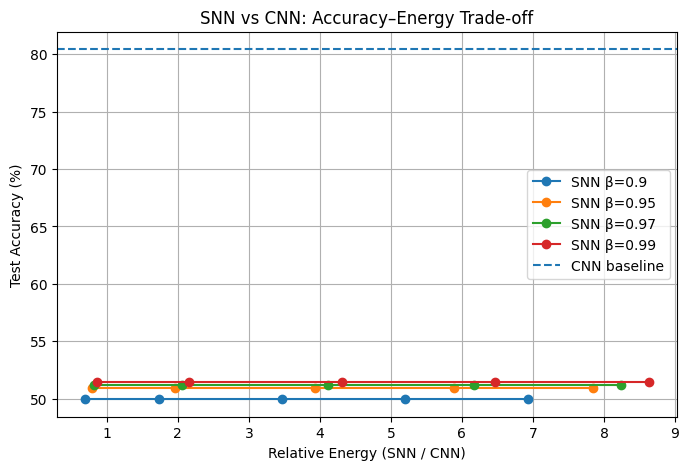

In [18]:
# %%
# Ensure numeric consistency
df["beta"] = df["beta"].apply(lambda x: float(x) if isinstance(x, (int, float)) else x)
df["T"] = df["T"].apply(lambda x: int(x) if isinstance(x, (int, float)) else x)

# Relative energy vs CNN baseline
cnn_energy = df[df["model"] == "CNN"]["energy_proxy"].iloc[0]
df["relative_energy"] = df["energy_proxy"] / cnn_energy

display(df)

# Plot: Test Accuracy vs Relative Energy
plt.figure(figsize=(8, 5))
for beta in [b for b in df["beta"].unique() if b != "-"]:
    sub = df[(df["model"] == "SNN") & (df["beta"] == beta)]
    plt.plot(sub["relative_energy"], sub["test_acc"], "o-", label=f"SNN β={beta}")

plt.axhline(
    y=test_acc_cnn * 100,
    linestyle="--",
    label="CNN baseline"
)

plt.xlabel("Relative Energy (SNN / CNN)")
plt.ylabel("Test Accuracy (%)")
plt.title("SNN vs CNN: Accuracy–Energy Trade-off")
plt.legend()
plt.grid(True)
plt.show()

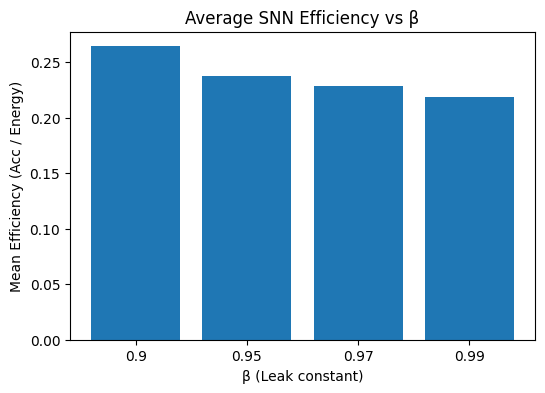

,beta,efficiency
0,0.90,0.264139
1,0.95,0.237841
2,0.97,0.228058
3,0.99,0.218625


In [19]:
# %%
snn_rows = df[df["model"] == "SNN"]
eff_by_beta = snn_rows.groupby("beta")["efficiency"].mean().reset_index()

plt.figure(figsize=(6, 4))
plt.bar(eff_by_beta["beta"].astype(str), eff_by_beta["efficiency"])
plt.xlabel("β (Leak constant)")
plt.ylabel("Mean Efficiency (Acc / Energy)")
plt.title("Average SNN Efficiency vs β")
plt.show()

display(eff_by_beta)

In [20]:
# %%
# Example: save the last SNN configuration (e.g., β=0.95, T=50)
beta_best = 0.95
T_best = 50

snn_best = SNN_KWS(cnn_model, num_steps=T_best, beta=beta_best).to(device)
snn_best.eval()

snn_save_path = MODEL_DIR / f"snn_kws_beta{beta_best}_T{T_best}.pt"
torch.save(snn_best.state_dict(), snn_save_path)

print("Saved SNN model to:", snn_save_path)

Saved SNN model to: /Users/maddy/Desktop/PLEP/Project/CS-576-Final-Project/saved_models/snn_kws_beta0.95_T50.pt
